In [132]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [133]:
#getting a list of files to be read
ex_table_files = glob.glob('*_extracted_table.txt')
# Sort the list of files based on the numeric part in the filenames
ex_table_files = sorted(ex_table_files, key=lambda x: int(x.split('_')[0]), reverse=True)

In [134]:

df_list = []

#read in files to dataframes, selecting relevant columns
for file in ex_table_files:
    df = pd.read_csv(file, delim_whitespace=True
                     , skiprows=1) 
    df = df[['p1','p2','rg','se','z','p']]
    df = df.iloc[:-2]
    df_list.append(df)

In [140]:
df_list[0]

,p1,p2,rg,se,z,p
0,munged/ADHD.sumstats.gz,munged/ANOREXIA.sumstats.gz,-0.0931,0.0370,-2.5141,1.193500e-02
1,munged/ADHD.sumstats.gz,munged/ANXIETY.sumstats.gz,0.3234,0.1350,2.3950,1.661900e-02
2,munged/ADHD.sumstats.gz,munged/ASD.sumstats.gz,0.4326,0.0513,8.4319,3.402200e-17
3,munged/ADHD.sumstats.gz,munged/AUD.sumstats.gz,-0.0135,0.0261,-0.5154,6.062400e-01
4,munged/ADHD.sumstats.gz,munged/BIL_CHIR.sumstats.gz,0.0809,0.0416,1.9447,5.181000e-02
5,munged/ADHD.sumstats.gz,munged/BIP.sumstats.gz,0.2366,0.0331,7.1576,8.210900e-13
6,munged/ADHD.sumstats.gz,munged/CUD.sumstats.gz,0.6633,0.0428,15.4853,4.359100e-54
7,munged/ADHD.sumstats.gz,munged/EPILEPSY.sumstats.gz,0.1418,0.0539,2.6332,8.458800e-03
8,munged/ADHD.sumstats.gz,munged/FATIGUE.sumstats.gz,0.0760,0.0718,1.0575,2.902800e-01
9,munged/ADHD.sumstats.gz,munged/GOUT.sumstats.gz,0.0647,0.0371,1.7435,8.125000e-02


In [136]:
disorders = ['ADHD','ANOREXIA', 'ANXIETY','ASD','AUD','BIL. CHIR','BIP','CUD','EPILEPSY','FATIGUE','GOUT','HOARDING','IBS','LUPUS','MDD','MIGRAINE','MS','MYASTHENIA','OCD','OD','PANIC','PARKINSONS','PTSD','RH. ARTHRITIS','SJOGRENS','SZC','THYROID DIS.','TOURETTES']

#make empty dataframes to fill with genetic correlation, and p-value
# Make empty array to fill with genetic correlation
gen_corr_array = np.zeros((len(disorders), len(disorders)))
#corr_pval_df = pd.DataFrame(index=disorders, columns=disorders)


In [168]:
gen_corr_array = np.zeros((len(disorders), len(disorders)))

# Assuming df_list is your list of dataframes
for i, df in enumerate(df_list):
    corr_val = df['rg'].values

    if len(corr_val) > 0:  # Check if 'rg' column is not empty
        for j in range(i + 1, len(corr_val) + 1 + i):  # Start from i + 1 to exclude the diagonal
            gen_corr_array[j, i] = corr_val[j - i - 1]
            

# Fill the diagonal with 1s
np.fill_diagonal(gen_corr_array, 1)

# Convert the filled cells to numeric (if the original values are not numeric)
gen_corr_array = gen_corr_array.astype(float)

# Create a DataFrame with disorders as column and index names
gen_corr_df = pd.DataFrame(gen_corr_array, index=disorders, columns=disorders)

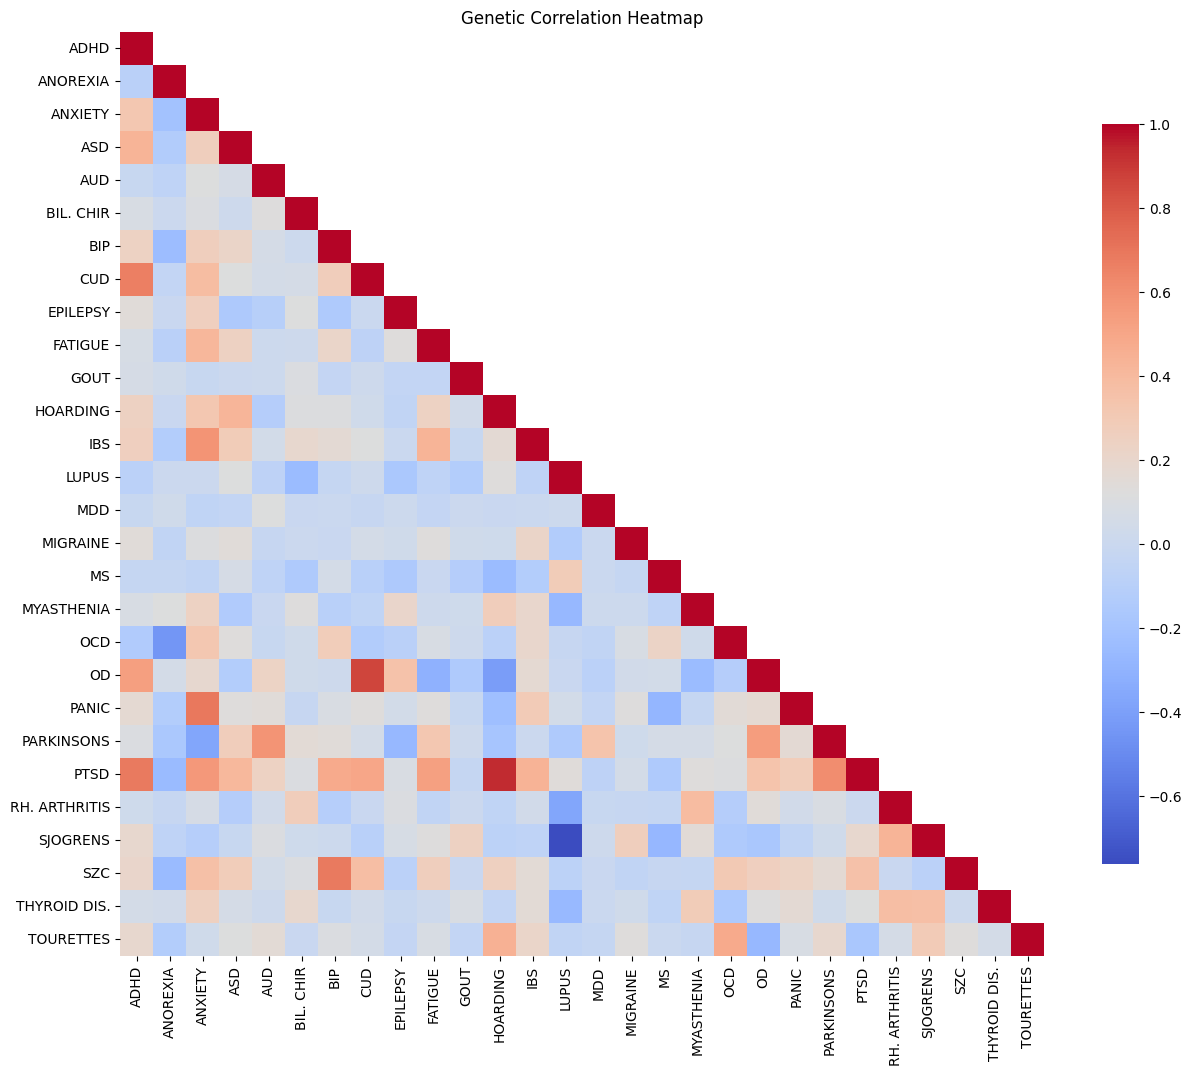

In [172]:
# Create a mask for the upper triangular part over the diagonal
mask = np.triu(np.ones_like(gen_corr_df), k=1)

# Plot the heatmap
plt.figure(figsize=(15,12))
sns.heatmap(gen_corr_df, cmap='coolwarm', mask=mask, square=True, cbar_kws={"shrink": 0.8})
plt.title('Genetic Correlation Heatmap')
plt.show()